In [2]:
import pickle
from utils.data import  DataLoader
from utils.metrics import calc_metrics
from utils.metrics import plot_cumulative_gain, plot_lift_chart, plot_lift_curve_custom
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from scikitplot.helpers import cumulative_gain_curve

In [3]:
dt_clf = pickle.load(open("models/dt_clf.pkl", 'rb'))
rf_clf = pickle.load(open("models/rf_clf.pkl", 'rb'))
lgb_clf = pickle.load(open("models/lgb.pkl", 'rb'))

In [4]:
dataset = "filtered"

if dataset == "filtered":
    filename='encoded/encoded_filtered_train_data_with_encoded_y.csv'
    test_filename='encoded/encoded_test_data_with_encoded_y.csv'

dl = DataLoader("./config.json")
dl.load_csv_data(filename=filename, test_filename=test_filename)
train_data = dl.get_data(include_target_column = True)
test_data = dl.get_test_data(include_target_column = True)
#train_data.info()
# split the data
X_train, y_train = dl.get_features_and_target(train_data)
X_test, y_test = dl.get_features_and_target(test_data)

loading test data from: C:\Users\dujem\PycharmProjects\bank-marketing\data\encoded/encoded_test_data_with_encoded_y.csv
loading data from: C:\Users\dujem\PycharmProjects\bank-marketing\data\encoded/encoded_filtered_train_data_with_encoded_y.csv
memory occupation before data type conversion: 13.82 MB
memory occupation after data type conversion: 7.04 MB
memory occupation before data type conversion: 1.6 MB
memory occupation after data type conversion: 820.71 KB


In [5]:
#prediction
def evaluate_sklearn_clf_on_test_set(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    calc_metrics(y_test, y_pred)
    return y_pred, y_pred_proba

In [6]:
def evaluate_lgb_on_test_set(clf, X_test, y_test):
    y_pred_proba = clf.predict(X_test)
    y_pred = np.copy(y_pred_proba)
    THRESHOLD = 0.5
    positive_inicies = y_pred > THRESHOLD
    negative_inicies = y_pred <= THRESHOLD
    y_pred[positive_inicies] = 1
    y_pred[negative_inicies] = 0
    
    calc_metrics(y_test, y_pred)
    y_pred_proba_new=np.vstack((1-y_pred_proba,y_pred_proba)).T
    return y_pred, y_pred_proba_new

In [7]:
def get_gains(y_true, y_probas):
    """
    Used code from https://github.com/reiinakano/scikit-plot/blob/26007fbf9f05e915bd0f6acb86850b01b00944cf/scikitplot/metrics.py
    """
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    classes = np.unique(y_true)
    if len(classes) != 2:
        raise ValueError('Cannot calculate Lift Curve for data with '
                         '{} category/ies'.format(len(classes)))
    
    percentages, gains1 = cumulative_gain_curve(y_true, y_probas[:, 0],
                                                classes[0])
    percentages, gains2 = cumulative_gain_curve(y_true, y_probas[:, 1],
                                                classes[1])
    
    return percentages, gains1, gains2

In [8]:
print("Decision tree:")
dt_y_pred, dt_y_pred_proba = evaluate_sklearn_clf_on_test_set(dt_clf, 
                                                              X_test, 
                                                              y_test)

print("\nRandom Forest:")
rf_y_pred, rf_y_pred_proba = evaluate_sklearn_clf_on_test_set(rf_clf, 
                                                              X_test, 
                                                              y_test)
print("\nXGBoost:")
lgb_y_pred, lgb_y_pred_proba = evaluate_lgb_on_test_set(lgb_clf, 
                                                        X_test, 
                                                        y_test)


Decision tree:
Auc:0.6204423950653702
Prec:0.6324324324324324
Rec:0.25942350332594233
Acc:0.9024034959941734
F1:0.36792452830188677
AP:0.24515547987027564

Random Forest:
Auc:0.6128000420729893
Prec:0.6488095238095238
Rec:0.24168514412416853
Acc:0.9026462733673222
F1:0.3521809369951535
AP:0.23983748488793522

XGBoost:
Auc:0.6277939850133111
Prec:0.6358974358974359
Rec:0.2749445676274945
Acc:0.9033746054867686
F1:0.3839009287925697
AP:0.2542247465879179


In [9]:
dt_percentages, base_gains, dt_gains = get_gains(y_test, dt_y_pred_proba)
rf_percentages, _, rf_gains = get_gains(y_test, rf_y_pred_proba)
lgb_percentages, _, lgb_gains = get_gains(y_test, lgb_y_pred_proba)

In [10]:
"""
y_test.value_counts()
0    3668
1     451 <- only 451 instances of positive class (10.94 %)
Name: y, dtype: int64
""";

In [11]:
def print_percentage(perc,gains, LOWER = 0.105, UPPER = 0.115):
# prints how many samples need to be taken (from whole population) in order to
# achieve the same percentage of positive samples that would be gotten by random sampling
# (how many instances need to be picked to have at least 10.94% of total positives)
    for per,gain in zip(perc, gains):
        if gain > LOWER:
            print("picking ", round(per*100, 2),"%", 
                  "gets you: ", round(gain*100, 2),"% of positive class samples",
                  int(per*4119), int(gain*451))
        if gain > UPPER:
            break

In [12]:
LOWER = 0.109
UPPER = 0.111
    
print_percentage(dt_percentages, dt_gains, LOWER=LOWER, UPPER=UPPER)
print("\n")
print_percentage(rf_percentages, rf_gains, LOWER=LOWER, UPPER=UPPER)
print("\n")
print_percentage(lgb_percentages, lgb_gains, LOWER=LOWER, UPPER=UPPER)

picking  1.58 % gets you:  11.09 % of positive class samples 65 50
picking  1.6 % gets you:  11.31 % of positive class samples 66 51


picking  1.48 % gets you:  11.09 % of positive class samples 61 50
picking  1.51 % gets you:  11.09 % of positive class samples 62 50
picking  1.53 % gets you:  11.31 % of positive class samples 63 51


picking  1.51 % gets you:  11.09 % of positive class samples 62 50
picking  1.53 % gets you:  11.31 % of positive class samples 63 51


In [13]:
def plot_all_cumulative_gain_curves(base_percentages, base_gains,
                                    dt_percentages, dt_gains,
                                    rf_percentages, rf_gains,
                                    lbg_percentages, lgb_gains):
    
    sns.set(rc={'figure.figsize':(10,10)}, font_scale=1.5)
    base_df = pd.DataFrame({"perc":[0,1], "gain": [0, 1]})
    dt_df = pd.DataFrame({"perc":dt_percentages, "gain": dt_gains})
    rf_df = pd.DataFrame({"perc":rf_percentages, "gain": rf_gains})
    lgb_df = pd.DataFrame({"perc":lbg_percentages, "gain": lgb_gains})

    ax = sns.lineplot(x="perc", y="gain", data=dt_df, label="Decision Tree")
    ax = sns.lineplot(x="perc", y="gain", data=base_df, label="Baseline")
    ax = sns.lineplot(x="perc", y="gain", data=rf_df, ax=ax, label="Random Forest")
    ax = sns.lineplot(x="perc", y="gain", data=lgb_df, ax=ax, label="XGBoost")

    #plt.title('Cumulative Gain plot')
    # Set x-axis label
    plt.xlabel('Percantage of samples')
    # Set y-axis label
    plt.ylabel('Cumulative percentage of positive samples')
    fig = ax.get_figure()
    fig.savefig("cumulative_gain_all.png", bbox_inches="tight")

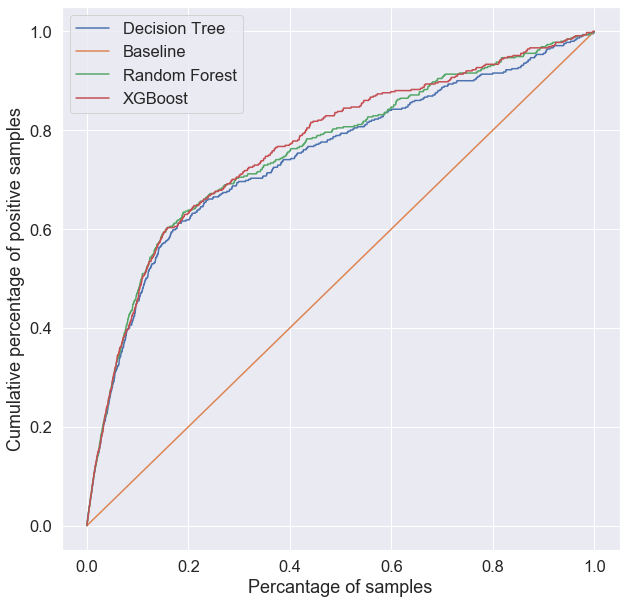

In [14]:
plot_all_cumulative_gain_curves(dt_percentages, base_gains,
                                dt_percentages, dt_gains,
                                rf_percentages, rf_gains,
                                lgb_percentages, lgb_gains)

In [15]:
def plot_all_lift_curves(base_percentages, base_gains,
                        dt_percentages, dt_gains,
                        rf_percentages, rf_gains,
                        lgb_percentages, lgb_gains):
    
    #base_percentages = base_percentages[1:]
    #base_gains = base_gains[1:]
    #base_gains = base_gains / base_percentages
    
    dt_percentages = dt_percentages[1:]
    dt_gains = dt_gains[1:]
    dt_gains = dt_gains / dt_percentages
    
    rf_percentages = rf_percentages[1:]
    rf_gains = rf_gains[1:]
    rf_gains = rf_gains / rf_percentages
    
    lgb_percentages = lgb_percentages[1:]
    lgb_gains = lgb_gains[1:]
    lgb_gains = lgb_gains / lgb_percentages
    
    sns.set(rc={'figure.figsize':(10,10)}, font_scale=1.5)
    base_df = pd.DataFrame({"perc":[0,1], "gain": [1, 1]})
    dt_df = pd.DataFrame({"perc":dt_percentages, "gain": dt_gains})
    rf_df = pd.DataFrame({"perc":rf_percentages, "gain": rf_gains})
    lgb_df = pd.DataFrame({"perc":lgb_percentages, "gain": lgb_gains})

    ax = sns.lineplot(x="perc", y="gain", data=dt_df, label="Decision Tree")
    ax = sns.lineplot(x="perc", y="gain", data=base_df, label="Baseline")
    ax = sns.lineplot(x="perc", y="gain", data=rf_df, ax=ax, label="Random Forest")
    ax = sns.lineplot(x="perc", y="gain", data=lgb_df, ax=ax, label="XGBoost")
    #plt.title('Lift chart')
    # Set x-axis label
    plt.xlabel('Percantage of contacted costumers')
    # Set y-axis label
    plt.ylabel('Lift')
    fig = ax.get_figure()
    fig.savefig("lift_all.png", bbox_inches="tight")

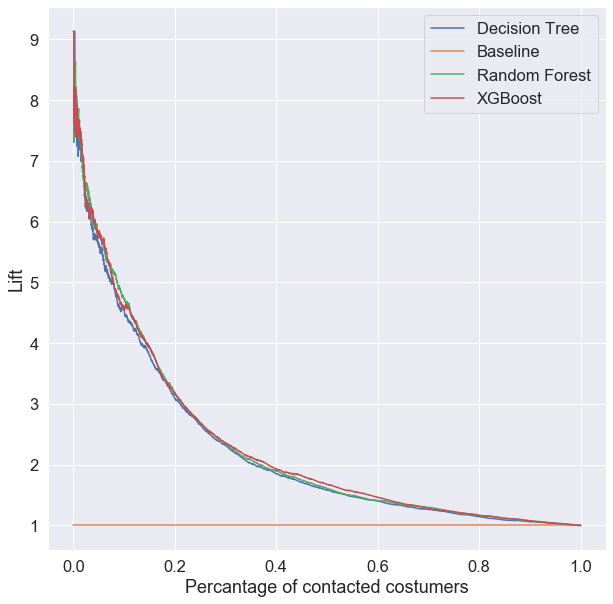

In [16]:
plot_all_lift_curves(dt_percentages, base_gains,
                    dt_percentages, dt_gains,
                    rf_percentages, rf_gains,
                    lgb_percentages, lgb_gains)